In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "rbc_phase"
ood = "0"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

RBC Dataset V.3 => Fractional Split OR Patient wise Split
Dataset split type train, image type: phase


Loaded 2752 images
RBC Dataset V.3 => Fractional Split OR Patient wise Split
Dataset split type val, image type: phase


Loaded 928 images
RBC Dataset V.3 => Fractional Split OR Patient wise Split
Dataset split type test, image type: phase


Loaded 928 images
RBC Dataset V.3 => Fractional Split OR Patient wise Split
Dataset split type train, image type: phase


Loaded 1462 images
RBC Dataset V.3 => Fractional Split OR Patient wise Split
Dataset split type val, image type: phase


Loaded 493 images
RBC Dataset V.3 => Fractional Split OR Patient wise Split
Dataset split type test, image type: phase


Loaded 493 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0 sqy0ovuk


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                                                          | 0/22 [00:00<?, ?it/s]

  5%|████████                                                                                                                                                                          | 1/22 [00:01<00:38,  1.84s/it]

  9%|████████████████▏                                                                                                                                                                 | 2/22 [00:02<00:17,  1.17it/s]

 14%|████████████████████████▎                                                                                                                                                         | 3/22 [00:02<00:10,  1.85it/s]

 18%|████████████████████████████████▎                                                                                                                                                 | 4/22 [00:02<00:07,  2.53it/s]

 23%|████████████████████████████████████████▍                                                                                                                                         | 5/22 [00:02<00:05,  3.19it/s]

 27%|████████████████████████████████████████████████▌                                                                                                                                 | 6/22 [00:02<00:04,  3.78it/s]

 32%|████████████████████████████████████████████████████████▋                                                                                                                         | 7/22 [00:02<00:03,  4.27it/s]

 36%|████████████████████████████████████████████████████████████████▋                                                                                                                 | 8/22 [00:03<00:02,  4.68it/s]

 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9/22 [00:03<00:02,  5.00it/s]

 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 10/22 [00:03<00:02,  5.24it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 11/22 [00:03<00:02,  5.43it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/22 [00:03<00:01,  5.56it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 13/22 [00:03<00:01,  5.64it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 14/22 [00:04<00:01,  5.72it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 15/22 [00:04<00:01,  5.78it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 16/22 [00:04<00:01,  5.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 17/22 [00:04<00:00,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18/22 [00:04<00:00,  5.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 19/22 [00:04<00:00,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 20/22 [00:05<00:00,  5.86it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 21/22 [00:05<00:00,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:05<00:00,  6.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:05<00:00,  4.09it/s]

train - OK


  0%|                                                                                                                                                                                           | 0/8 [00:00<?, ?it/s]

 12%|██████████████████████▍                                                                                                                                                            | 1/8 [00:00<00:02,  2.55it/s]

 25%|████████████████████████████████████████████▊                                                                                                                                      | 2/8 [00:00<00:01,  3.81it/s]

 38%|███████████████████████████████████████████████████████████████████▏                                                                                                               | 3/8 [00:00<00:01,  4.53it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 4/8 [00:00<00:00,  4.99it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5/8 [00:01<00:00,  5.27it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6/8 [00:01<00:00,  5.45it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 7/8 [00:01<00:00,  5.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]

val - OK


  0%|                                                                                                                                                                                           | 0/8 [00:00<?, ?it/s]

 12%|██████████████████████▍                                                                                                                                                            | 1/8 [00:00<00:02,  2.60it/s]

 25%|████████████████████████████████████████████▊                                                                                                                                      | 2/8 [00:00<00:01,  3.85it/s]

 38%|███████████████████████████████████████████████████████████████████▏                                                                                                               | 3/8 [00:00<00:01,  4.57it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 4/8 [00:00<00:00,  5.01it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5/8 [00:01<00:00,  5.29it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6/8 [00:01<00:00,  5.46it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 7/8 [00:01<00:00,  5.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]

test InD - OK


  0%|                                                                                                                                                                                          | 0/20 [00:00<?, ?it/s]

  5%|████████▉                                                                                                                                                                         | 1/20 [00:00<00:07,  2.54it/s]

 10%|█████████████████▊                                                                                                                                                                | 2/20 [00:00<00:04,  3.80it/s]

 15%|██████████████████████████▋                                                                                                                                                       | 3/20 [00:00<00:03,  4.54it/s]

 20%|███████████████████████████████████▌                                                                                                                                              | 4/20 [00:00<00:03,  4.98it/s]

 25%|████████████████████████████████████████████▌                                                                                                                                     | 5/20 [00:01<00:02,  5.26it/s]

 30%|█████████████████████████████████████████████████████▍                                                                                                                            | 6/20 [00:01<00:02,  5.44it/s]

 35%|██████████████████████████████████████████████████████████████▎                                                                                                                   | 7/20 [00:01<00:02,  5.56it/s]

 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                          | 8/20 [00:01<00:02,  5.65it/s]

 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                  | 9/20 [00:01<00:01,  5.71it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 10/20 [00:01<00:01,  5.75it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 11/20 [00:02<00:01,  5.78it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 12/20 [00:02<00:01,  5.80it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 13/20 [00:02<00:01,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 14/20 [00:02<00:01,  5.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 15/20 [00:02<00:00,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 16/20 [00:02<00:00,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 17/20 [00:03<00:00,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 18/20 [00:03<00:00,  5.85it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 19/20 [00:03<00:00,  5.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.58it/s]

test OoD - OK


  0%|                                                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                                               | 1/100 [00:00<00:14,  6.64it/s]

  2%|███▌                                                                                                                                                                             | 2/100 [00:00<00:14,  6.66it/s]

  3%|█████▎                                                                                                                                                                           | 3/100 [00:00<00:14,  6.68it/s]

  4%|███████                                                                                                                                                                          | 4/100 [00:00<00:14,  6.68it/s]

  5%|████████▊                                                                                                                                                                        | 5/100 [00:00<00:14,  6.69it/s]

  6%|██████████▌                                                                                                                                                                      | 6/100 [00:00<00:14,  6.69it/s]

  7%|████████████▍                                                                                                                                                                    | 7/100 [00:01<00:13,  6.69it/s]

  8%|██████████████▏                                                                                                                                                                  | 8/100 [00:01<00:13,  6.69it/s]

  9%|███████████████▉                                                                                                                                                                 | 9/100 [00:01<00:13,  6.69it/s]

 10%|█████████████████▌                                                                                                                                                              | 10/100 [00:01<00:13,  6.69it/s]

 11%|███████████████████▎                                                                                                                                                            | 11/100 [00:01<00:13,  6.69it/s]

 12%|█████████████████████                                                                                                                                                           | 12/100 [00:01<00:13,  6.70it/s]

 13%|██████████████████████▉                                                                                                                                                         | 13/100 [00:01<00:12,  6.70it/s]

 14%|████████████████████████▋                                                                                                                                                       | 14/100 [00:02<00:12,  6.70it/s]

 15%|██████████████████████████▍                                                                                                                                                     | 15/100 [00:02<00:12,  6.70it/s]

 16%|████████████████████████████▏                                                                                                                                                   | 16/100 [00:02<00:12,  6.70it/s]

 17%|█████████████████████████████▉                                                                                                                                                  | 17/100 [00:02<00:12,  6.70it/s]

 18%|███████████████████████████████▋                                                                                                                                                | 18/100 [00:02<00:12,  6.70it/s]

 19%|█████████████████████████████████▍                                                                                                                                              | 19/100 [00:02<00:12,  6.69it/s]

 20%|███████████████████████████████████▏                                                                                                                                            | 20/100 [00:02<00:11,  6.70it/s]

 21%|████████████████████████████████████▉                                                                                                                                           | 21/100 [00:03<00:11,  6.70it/s]

 22%|██████████████████████████████████████▋                                                                                                                                         | 22/100 [00:03<00:11,  6.70it/s]

 23%|████████████████████████████████████████▍                                                                                                                                       | 23/100 [00:03<00:11,  6.70it/s]

 24%|██████████████████████████████████████████▏                                                                                                                                     | 24/100 [00:03<00:11,  6.70it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 25/100 [00:03<00:11,  6.70it/s]

 26%|█████████████████████████████████████████████▊                                                                                                                                  | 26/100 [00:03<00:11,  6.70it/s]

 27%|███████████████████████████████████████████████▌                                                                                                                                | 27/100 [00:04<00:10,  6.70it/s]

 28%|█████████████████████████████████████████████████▎                                                                                                                              | 28/100 [00:04<00:10,  6.70it/s]

 29%|███████████████████████████████████████████████████                                                                                                                             | 29/100 [00:04<00:10,  6.70it/s]

 30%|████████████████████████████████████████████████████▊                                                                                                                           | 30/100 [00:04<00:10,  6.70it/s]

 31%|██████████████████████████████████████████████████████▌                                                                                                                         | 31/100 [00:04<00:10,  6.70it/s]

 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 32/100 [00:04<00:10,  6.70it/s]

 33%|██████████████████████████████████████████████████████████                                                                                                                      | 33/100 [00:04<00:10,  6.69it/s]

 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 34/100 [00:05<00:09,  6.70it/s]

 35%|█████████████████████████████████████████████████████████████▌                                                                                                                  | 35/100 [00:05<00:09,  6.70it/s]

 36%|███████████████████████████████████████████████████████████████▎                                                                                                                | 36/100 [00:05<00:09,  6.70it/s]

 37%|█████████████████████████████████████████████████████████████████                                                                                                               | 37/100 [00:05<00:09,  6.70it/s]

 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 38/100 [00:05<00:09,  6.70it/s]

 39%|████████████████████████████████████████████████████████████████████▋                                                                                                           | 39/100 [00:05<00:09,  6.70it/s]

 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 40/100 [00:05<00:08,  6.70it/s]

 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                       | 41/100 [00:06<00:08,  6.70it/s]

 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 42/100 [00:06<00:08,  6.70it/s]

 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                    | 43/100 [00:06<00:08,  6.70it/s]

 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 44/100 [00:06<00:08,  6.70it/s]

 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 45/100 [00:06<00:08,  6.70it/s]

 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 46/100 [00:06<00:08,  6.70it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 47/100 [00:07<00:07,  6.70it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 48/100 [00:07<00:07,  6.70it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 49/100 [00:07<00:07,  6.70it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 50/100 [00:07<00:07,  6.70it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 51/100 [00:07<00:07,  6.70it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 52/100 [00:07<00:07,  6.70it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 53/100 [00:07<00:07,  6.70it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 54/100 [00:08<00:06,  6.70it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 55/100 [00:08<00:06,  6.70it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 56/100 [00:08<00:06,  6.70it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 57/100 [00:08<00:06,  6.70it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 58/100 [00:08<00:06,  6.70it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 59/100 [00:08<00:06,  6.70it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 60/100 [00:08<00:05,  6.70it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 61/100 [00:09<00:05,  6.70it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 62/100 [00:09<00:05,  6.70it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 63/100 [00:09<00:05,  6.70it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 64/100 [00:09<00:05,  6.70it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 65/100 [00:09<00:05,  6.70it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 66/100 [00:09<00:05,  6.70it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 67/100 [00:10<00:04,  6.70it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 68/100 [00:10<00:04,  6.70it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 69/100 [00:10<00:04,  6.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 70/100 [00:10<00:04,  6.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 71/100 [00:10<00:04,  6.70it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 72/100 [00:10<00:04,  6.70it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 73/100 [00:10<00:04,  6.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 74/100 [00:11<00:03,  6.70it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 75/100 [00:11<00:03,  6.70it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 76/100 [00:11<00:03,  6.70it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 77/100 [00:11<00:03,  6.70it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/100 [00:11<00:03,  6.70it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 79/100 [00:11<00:03,  6.70it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 80/100 [00:11<00:02,  6.70it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 81/100 [00:12<00:02,  6.70it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 82/100 [00:12<00:02,  6.70it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 83/100 [00:12<00:02,  6.70it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 84/100 [00:12<00:02,  6.70it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 85/100 [00:12<00:02,  6.70it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 86/100 [00:12<00:02,  6.70it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 87/100 [00:12<00:01,  6.70it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 88/100 [00:13<00:01,  6.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 89/100 [00:13<00:01,  6.70it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 90/100 [00:13<00:01,  6.70it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 91/100 [00:13<00:01,  6.70it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 92/100 [00:13<00:01,  6.70it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 93/100 [00:13<00:01,  6.70it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 94/100 [00:14<00:00,  6.70it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 95/100 [00:14<00:00,  6.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 96/100 [00:14<00:00,  6.70it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 97/100 [00:14<00:00,  6.70it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 98/100 [00:14<00:00,  6.70it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 99/100 [00:14<00:00,  6.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.70it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(2752, 1, 64, 64) (2752, 512) (2752, 3584) (2752, 1, 64, 64) (2752,)
(928, 1, 64, 64) (928, 512) (928, 3584) (928, 1, 64, 64) (928,)
(928, 1, 64, 64) (928, 512) (928, 3584) (928, 1, 64, 64) (928,)
(2448, 1, 64, 64) (2448, 512) (2448, 3584) (2448, 1, 64, 64) (2448,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(928, 2) (2448, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(928, 2) (2448, 2)


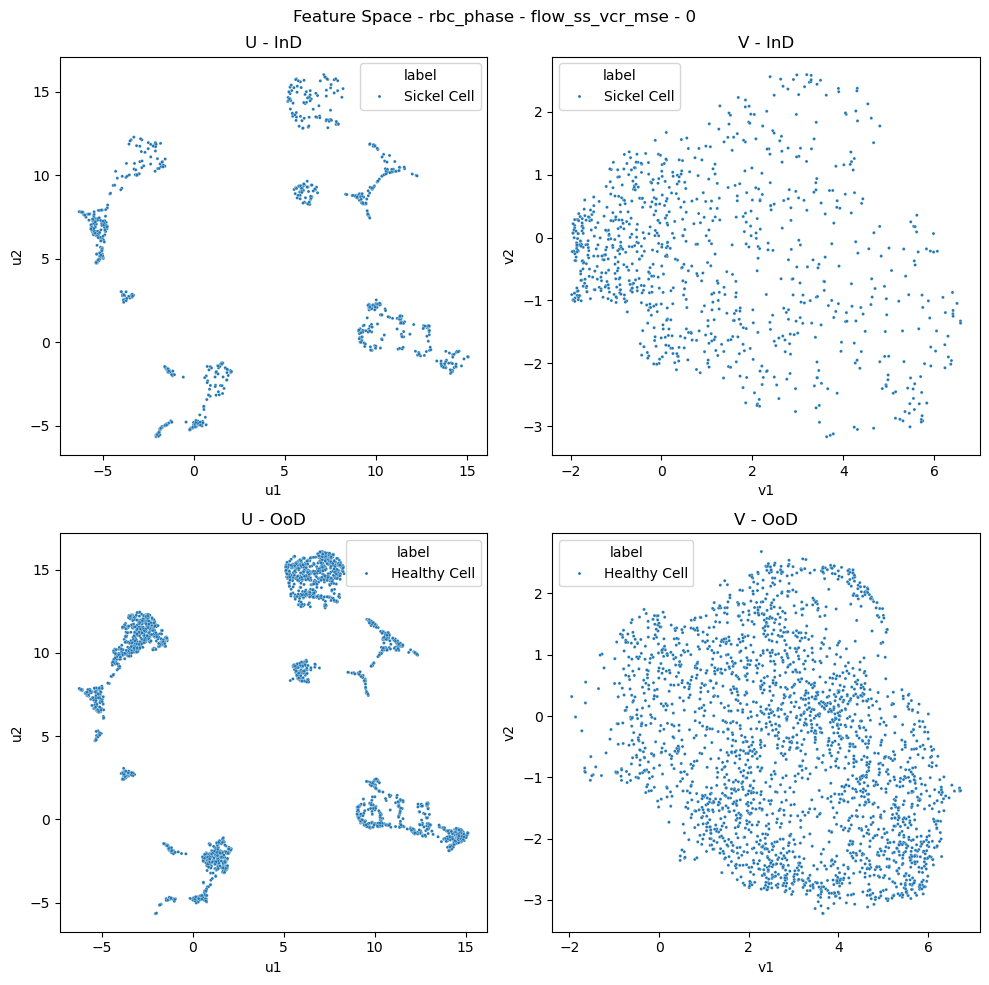

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

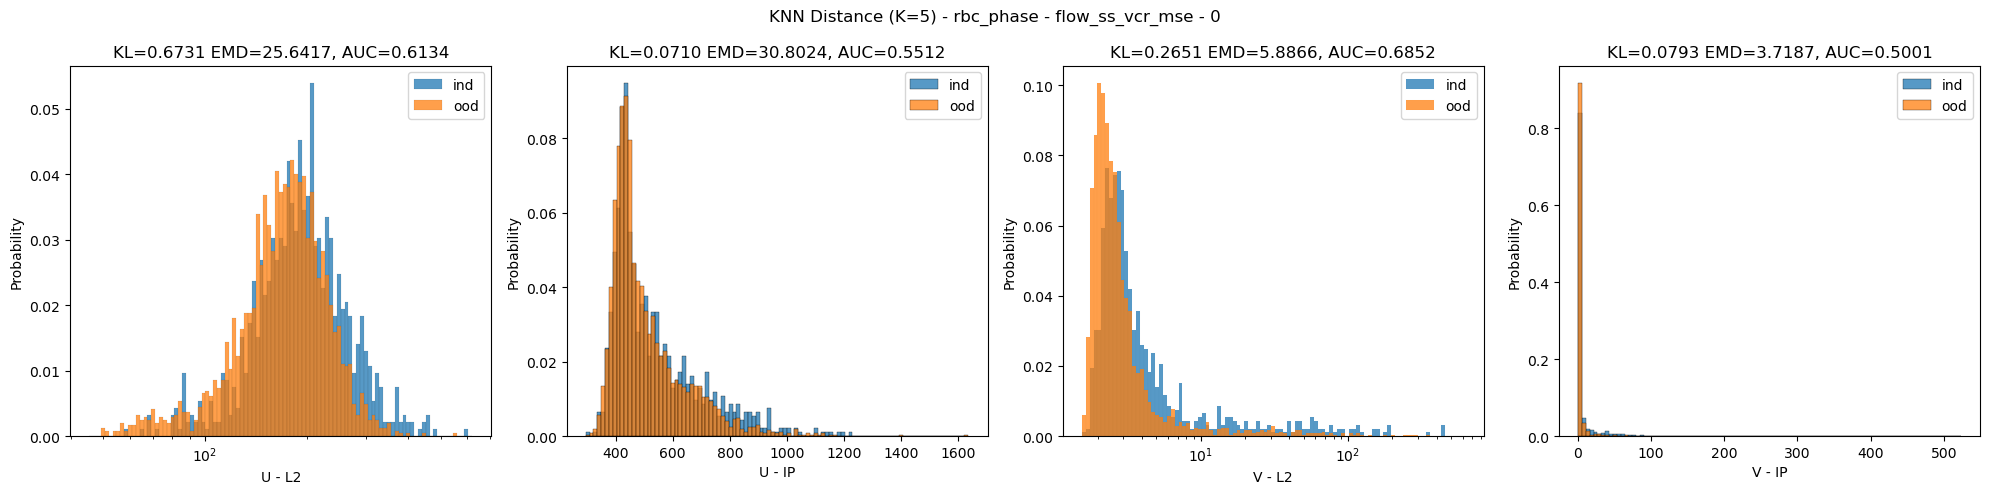

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

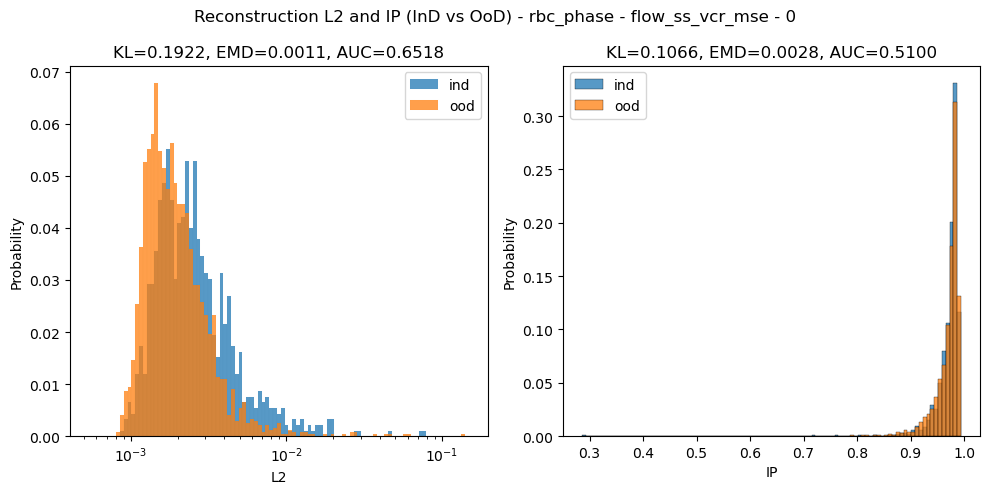

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

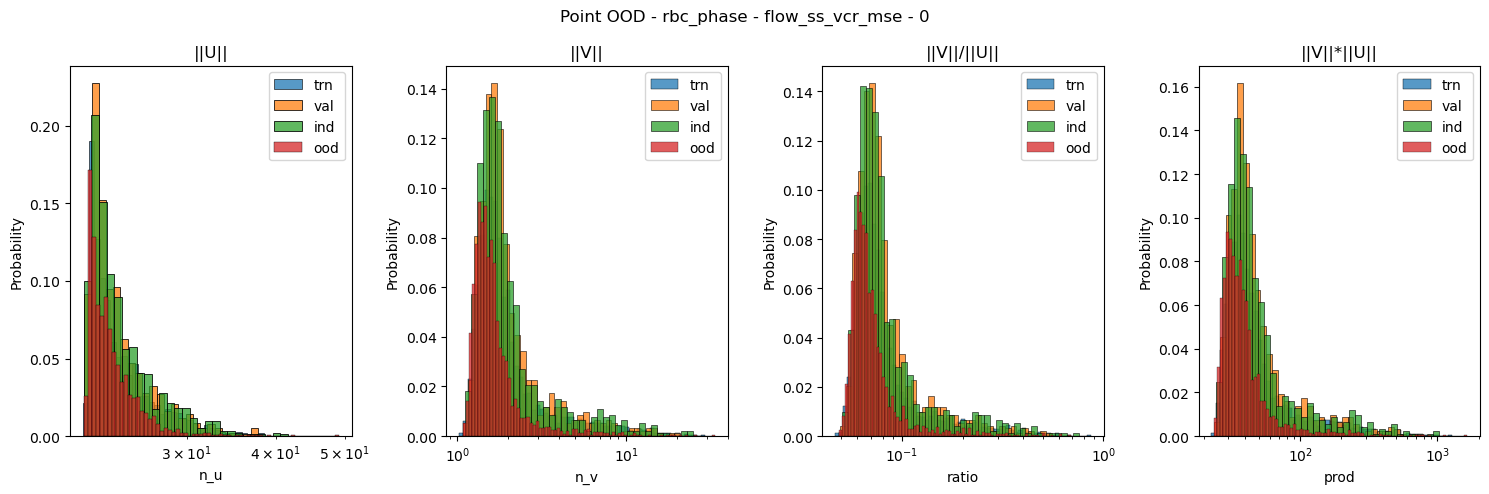

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


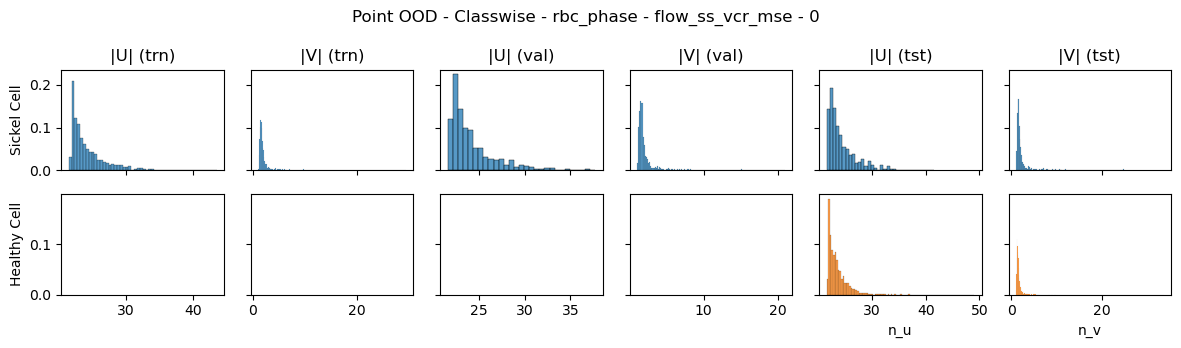

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

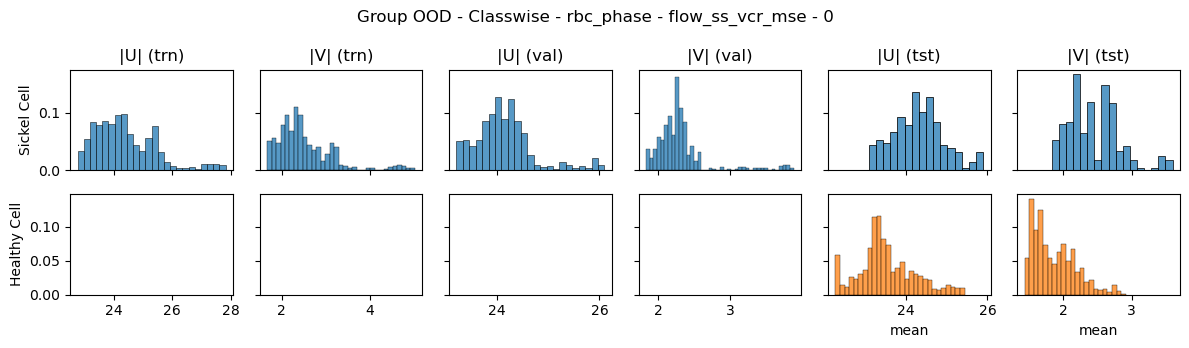

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)